# Project 

This is the project for course EE4540 Distributed Signal Processing.

Environment:

Python = 3.12

In [31]:
import numpy as np
from scipy.spatial import distance_matrix
import networkx as nx
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from matplotlib.colors import LinearSegmentedColormap
# import seaborn as sns
import time
import random
from math import log, pi, ceil
from scipy.optimize import fsolve

## Q1
# 复制过来

In [32]:
selection = input(" Do you like the communication radius fixed(option 1) or the number of sensors fixed(option 2)?")
if selection != "1" and selection != "2":
    print("Holy shit!")
else:
    print("")
    selection_2 = input("Do you want to check certain number of your choice(option 1) or you want to see a tendency(option 2)?")
    if selection_2 != "1" and selection_2 != "2":
        print("Holy shit again!")

if selection == "1":
    if selection_2 == "1":
        selection_final = 1
    else:
        selection_final = 2
elif selection_2 == "1":
    selection_final = 3
else:
    selection_final = 4
print(selection_final)


2


In [33]:
# Definition of the sizes
Area_Length = 100              # The length of the area, both length and width are the same
Area_Size = Area_Length ** 2
Area_Coverage = 0.999          # Define the total coverage of the sensors
Connected_Prob = 0.99


# Known r, calculate n
def nodes_for_coverage(area_size, Comm_Radius, coverage_required):
    return ceil(-area_size * np.log(1 - coverage_required) / (pi * Comm_Radius ** 2))


# Minimum amount of sensors according to RGG
def nodes_for_connectivity(normalized_radius, dimension, probability):
    def equation(n_array):
        '''This is the equation for RGG'''
        return (2 * np.log(n_array[0])) / n_array[0] - normalized_radius ** dimension

    n_array = [10.0]
    n_connectivity = fsolve(equation, n_array)  # Calculation the equation equals to 0, n_array is a start point
    # Consider the probability of connection
    n_prob = ceil(np.sqrt(1 / (1 - probability)))

    return max(int(ceil(n_connectivity[0])), n_prob)

def nodes_final (Comm_Radius):
    # Calculate number of nodes
    n_coverage = nodes_for_coverage(Area_Size, Comm_Radius, Area_Coverage)
    print(f"Minimum sensors required for coverage: {n_coverage}")
    n_connectivity = nodes_for_connectivity(Comm_Radius / Area_Length, dimension=2, probability=Connected_Prob)
    print(f"Minimum sensors required for connectivity: {n_connectivity}")

    n_final = max(n_connectivity, n_coverage)
    print(f"Final number of sensors used: {n_final}")
    # Random place the sensors
    # np.random.seed(42)
    sensor_location = np.random.uniform(0, Area_Length, (n_final, 2))

    # Calculate Euclidean distance matrix
    Euc_matrix = distance_matrix(sensor_location, sensor_location)

    # Calculate adjacency matrix
    adj_matrix = (Euc_matrix <= Comm_Radius) & (Euc_matrix > 0)

    # Build network graph
    Graphs = nx.Graph()
    for i in range(n_final):
        Graphs.add_node(i, pos=tuple(sensor_location[i]))

    for j in range(n_final):
        for k in range(j + 1, n_final):
            if adj_matrix[j, k]:
                Graphs.add_edge(j, k)
    return(Graphs, n_final, sensor_location)

Minimum sensors required for coverage: 220
Minimum sensors required for connectivity: 1457
Final number of sensors used: 1457
The graph is connected


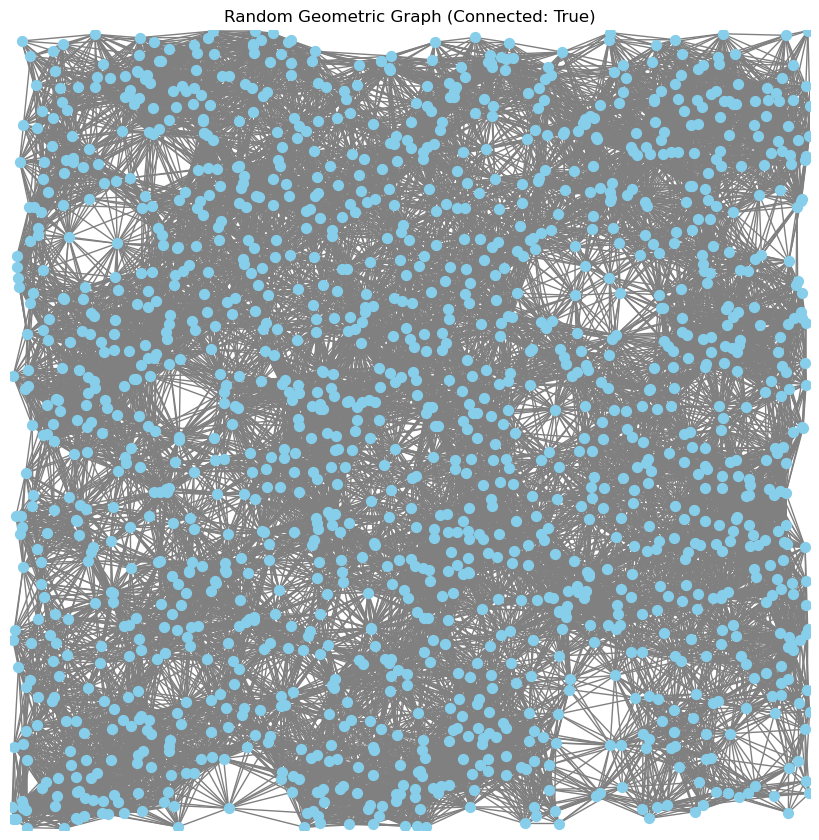

In [34]:
if selection_final == 1:
    # Circle for different r
    r_values = []
    n_values = []
    connected_count = 0
    disconnected_count = 0
    for Comm_Radius in range(5, 100, 1):

        Graphs, n_final,_ = nodes_final(Comm_Radius)
        # Check connectivity
        connection_state = nx.is_connected(Graphs)
        if connection_state:
            print("The graph is connected")
            connected_count += 1
            r_values.append(Comm_Radius)
            n_values.append(n_final)
        else:
            print("The graph is not connected")

    print(f"Connected graphs: {connected_count}")
    print(f"Disconnected graphs: {disconnected_count}")

    # Plot r vs n
    plt.figure(figsize=(10, 6))
    plt.plot(r_values, n_values, marker='o')
    plt.xlabel("Communication Radius r (m)")
    plt.ylabel("Required Number of Sensors n")
    plt.yscale('log')
    plt.title("Relation between r and n (Connected graphs only)")
    plt.grid(True)
    plt.show()
if selection_final == 2:
    Comm_Radius = input("Please input the communication Radius r (m):")
    Graphs, n_final, sensor_location = nodes_final(int(Comm_Radius))
    connection_state = nx.is_connected(Graphs)
    if connection_state:
        print("The graph is connected")
    else:
        print("The graph is not connected")
    # Visualize the graph
    pos_dict = {i: sensor_location[i] for i in range(n_final)}
    plt.figure(figsize=(8, 8))
    nx.draw(Graphs, pos=pos_dict, node_size=50, with_labels=False,
            node_color='skyblue', edge_color='gray')
    plt.title(f"Random Geometric Graph (Connected: {connection_state})")
    plt.grid(True)
    plt.xlim(0, Area_Length)
    plt.ylim(0, Area_Length)
    plt.show()


# Known n, calculate r

def radius_for_coverage(number_nodes):
    r_cov = np.sqrt(-Area_Size * log(1 - Area_Coverage) / (pi * number_nodes))
    maximum_radius = Area_Length * np.sqrt(2)
    if r_cov > maximum_radius:
        return maximum_radius
    else:
        return r_cov

def radius_for_connectivity(number_nodes):
    if (1 - 1/(number_nodes **2)) < Connected_Prob:
        maximum_radius = Area_Length * np.sqrt(2)
        return maximum_radius
    else:
        r_conn = Area_Length * np.sqrt(2 * log(number_nodes)/number_nodes)
        return r_conn

def radius_final(number_nodes):
    r_coverage = radius_for_coverage(number_nodes)
    print(f"Minimum radius required for coverage: {r_coverage}")
    r_connectivity = radius_for_connectivity(number_nodes)
    print(f"Minimum radius of sensors required for connectivity: {r_connectivity}")

    r_final = max(r_connectivity, r_coverage)
    print(f"Final radius of sensors used: {r_final}")
    # Random place the sensors
    # np.random.seed(42)
    sensor_location = np.random.uniform(0, Area_Length, (number_nodes, 2))

    # Calculate Euclidean distance matrix
    Euc_matrix = distance_matrix(sensor_location, sensor_location)

    # Calculate adjacency matrix
    adj_matrix = (Euc_matrix <= r_final) & (Euc_matrix > 0)

    # Build network graph
    Graphs = nx.Graph()
    for i in range(number_nodes):
        Graphs.add_node(i, pos=tuple(sensor_location[i]))

    for j in range(number_nodes):
        for k in range(j + 1, number_nodes):
            if adj_matrix[j, k]:
                Graphs.add_edge(j, k)
    return(Graphs, r_final, sensor_location)


if selection_final == 3:
    # Circle for different n
    r_values = []
    n_values = []
    connected_count = 0
    disconnected_count = 0
    for number_nodes in range(1, 1000, 50):

        Graphs, r_final,_ = radius_final(number_nodes)
        # Check connectivity
        connection_state = nx.is_connected(Graphs)
        if connection_state:
            print("The graph is connected")
            connected_count += 1
            r_values.append(r_final)
            n_values.append(number_nodes)
        else:
            print("The graph is not connected")

    print(f"Connected graphs: {connected_count}")
    print(f"Disconnected graphs: {disconnected_count}")

    # Plot r vs n
    plt.figure(figsize=(10, 6))
    plt.plot(n_values, r_values, marker='o')
    plt.xlabel("Number of Sensors n")
    plt.ylabel("Required Communication Radius r (m)")
    #plt.yscale('log')
    plt.title("Relation between n and r (Connected graphs only)")
    plt.grid(True)
    plt.show()

if selection_final == 4:
    number_nodes = input("Please input the number of sensors:")
    Graphs, r_final, sensor_location = radius_final(int(number_nodes))
    connection_state = nx.is_connected(Graphs)
    if connection_state:
        print("The graph is connected")
    else:
        print("The graph is not connected")
    # Visualize the graph
    pos_dict = {i: sensor_location[i] for i in range(int(number_nodes))}
    plt.figure(figsize=(8, 8))
    nx.draw(Graphs, pos=pos_dict, node_size=50, with_labels=False,
            node_color='skyblue', edge_color='gray')
    plt.title(f"Random Geometric Graph (Connected: {connection_state})")
    plt.grid(True)
    plt.xlim(0, Area_Length)
    plt.ylim(0, Area_Length)
    plt.show()

## Q2
Averaging
### randomised gossip

In [35]:
# randomised gossip

# 设置随机种子
np.random.seed(42)
random.seed(42)



In [36]:
# 随机Gossip算法实现
def randomised_gossip(init_values, adj_matrix, global_avg, max_iterations=5000, convergence_threshold=1e-6):
    """实现随机Gossip算法计算平均值"""
    # 全局平均值仅用于验证，实际分布式算法中不用

    values = init_values.copy()
    n = len(values)
    
    # 初始化历史记录
    history = {
        # 'node_values': [],
        # 'avg_estimates': [],
        'errors': [],
        'transmissions': 0
    }
    
    # 初始状态
    # history['node_values'].append(np.array([graph.nodes[i]['value'] for i in graph.nodes]))
    # history['avg_estimates'].append(np.array([graph.nodes[i]['avg_value'] for i in graph.nodes]))
    history['errors'].append(np.sum((values - global_avg) ** 2))
    
    iteration = 0
    
    while iteration < max_iterations:
        # 随机选择一个节点
        node_i = random.randint(0, n - 1)
        
        # 随机选择一个邻居
        neighbors = [idx for idx, connected in enumerate(adj_matrix[node_i]) if connected]
        if not neighbors:
            continue
        node_j = random.choice(neighbors)
        
        # 交换值并更新
        value_i = values[node_i]
        value_j = values[node_j]
        
        # 计算平均值
        new_value = (value_i + value_j) / 2.0
        
        # 更新两个节点的值
        values[node_i] = new_value
        values[node_j] = new_value
        
        # 记录传输次数
        history['transmissions'] += 2  # 双向通信

        iteration += 1
        
        # 记录当前状态
        if iteration % 10 == 0:  # 每10次迭代记录一次
            # current_values = np.array([graph.nodes[i]['avg_value'] for i in graph.nodes])
            # history['node_values'].append(current_values.copy())
            # history['avg_estimates'].append(np.mean(current_values))
            current_error = np.sum((values - global_avg) ** 2)
            history['errors'].append(current_error)
            
            # 检查收敛
            if current_error < convergence_threshold:
                break
        
    return values, history



随机生成结点和相应联通边

n=120 r=30

In [37]:
# Definition of the sizes
Area_Length = 100              # The length of the area, both length and width are the same
Area_Size = Area_Length ** 2
Area_Coverage = 0.999          # Define the total coverage of the sensors
Connected_Prob = 0.99

In [38]:
n = 50                   # Number of sensors
Comm_Radius = 40          # Communication radius of each sensor

sensor_location = np.random.uniform(0, Area_Length, (n, 2))

# Calculate Euclidean distance matrix
Euc_matrix = distance_matrix(sensor_location, sensor_location)

# Calculate adjacency matrix
adj_matrix = (Euc_matrix <= Comm_Radius) & (Euc_matrix > 0)
print(adj_matrix)

# Build network graph
Graphs = nx.Graph()
for i in range(n):
    Graphs.add_node(i, pos = tuple(sensor_location[i]))

for j in range(n):
    for k in range (j+1, n):
        if adj_matrix[j,k]:
            Graphs.add_edge(j, k)
print(f"Network connected: {nx.is_connected(Graphs)}")
print(f"Number of edges: {Graphs.number_of_edges()}")

[[False False False ... False False False]
 [False False False ...  True  True False]
 [False False False ... False False  True]
 ...
 [False  True False ... False  True False]
 [False  True False ...  True False False]
 [False False  True ... False False False]]
Network connected: True
Number of edges: 395


In [39]:
# 初始值
init_values = np.random.uniform(20, 30, n)
global_avg = np.mean(init_values)
print(f"Global average: {global_avg:.4f}")


Global average: 24.7830


In [40]:
# 运行随机Gossip算法
print("\nRunning randomised gossip algorithm...")
start_time = time.time()
final_values, history = randomised_gossip(init_values, adj_matrix, global_avg, max_iterations=3000)
elapsed_time = time.time() - start_time

# 输出结果
final_avg = np.mean(final_values)
final_error = history['errors'][-1]  # 最后一次记录的误差

print("\nAlgorithm completed!")
print(f"Total iterations: {len(history['errors'])*10}")
print(f"Total transmissions: {history['transmissions']}")
print(f"Execution time: {elapsed_time:.4f} seconds")
print(f"Final estimated average: {final_avg:.8f}")
print(f"Global average: {global_avg:.8f}")
print(f"Absolute error: {abs(final_avg - global_avg):.8f}")
print(f"Mean square error: {final_error:.8f}")
# print(f"Converged: {'Yes' if converged else 'No'}")



Running randomised gossip algorithm...

Algorithm completed!
Total iterations: 3010
Total transmissions: 6000
Execution time: 0.0073 seconds
Final estimated average: 24.78299917
Global average: 24.78299917
Absolute error: 0.00000000
Mean square error: 0.00000164


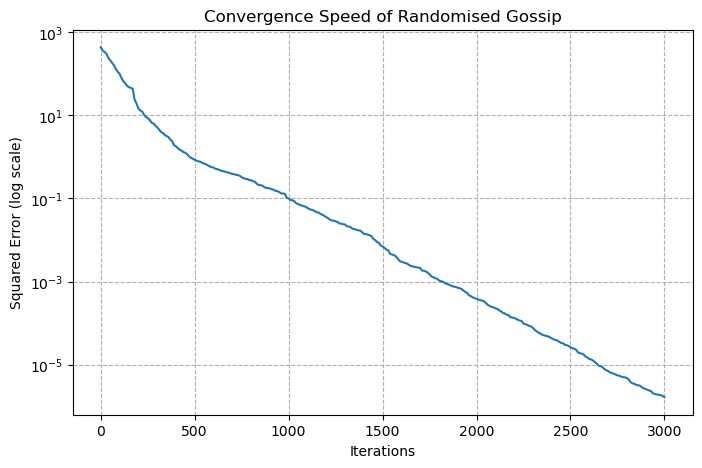

In [41]:
# convergence speed
# 绘制收敛速度图
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history['errors'])) * 10, history['errors'])
plt.xlabel('Iterations')
plt.ylabel('Squared Error (log scale)')
plt.title('Convergence Speed of Randomised Gossip')
plt.grid(True, which="both", ls="--")
plt.show()

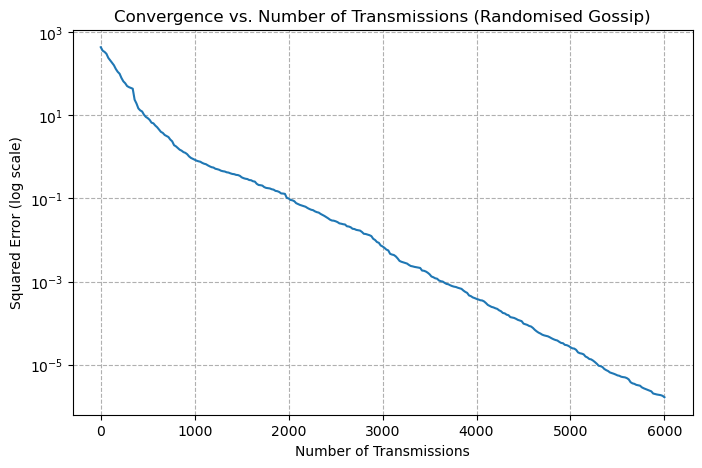

In [42]:
# number of transmissions
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history['errors'])) * 10 * 2, history['errors'])
plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('Convergence vs. Number of Transmissions (Randomised Gossip)')
plt.grid(True, which="both", ls="--")
plt.show()

### PDMM

In [43]:
def pdmm_average_consensus(
        v,               # Initial observations (array)
        adj,             # Adjacency matrix (bool 2-D)
        rho=1.0,         # Penalty parameter ρ
        max_iter=5000,
        tol=1e-6,
        log_freq=10,
        verbose=False):
    """
    PDMM / edge-based ADMM for average consensus.
    Returns: x, history={'errors','tx_curve','transmissions'}
    """
    n = len(v)
    Gdeg = np.sum(adj, axis=1)          # Degree d_i of each node
    edges = [(i, j) for i in range(n) for j in range(i+1, n) if adj[i, j]]
    lam   = {e: 0.0 for e in edges}     # Store one λ_{ij} per edge with i < j
    x     = v.copy()                    # Initialize x with local values

    # ---------- Logging statistics ----------
    avg      = v.mean()
    err_hist = [np.sum((x - avg) ** 2)]   # Initial squared error
    tx_hist  = [0]                        # Total number of scalar transmissions
    per_iter_tx = 2 * len(edges)         # Each edge transmits two scalars per iteration

    # ---------- Main iteration loop ----------
    for k in range(1, max_iter + 1):
        x_new = np.empty_like(x)

        # ----- Primal update: x_i -----
        for i in range(n):
            s_x, s_lam = 0.0, 0.0
            for j in range(n):
                if not adj[i, j]:
                    continue
                e = (i, j) if i < j else (j, i)          # Edge identifier
                sign = +1 if i < j else -1               # Orientation σ_ij
                s_x   += x[j]                            # Sum of neighbors' x_j
                s_lam += sign * lam[e]                   # Sum of Lagrange terms
            x_new[i] = (v[i] - s_lam + rho * s_x) / (1 + rho * Gdeg[i])

        # ----- Dual update: λ_{ij} -----
        for (i, j) in edges:
            lam[(i, j)] += rho * (x_new[i] - x_new[j])

        x = x_new

        # ----- Logging and convergence check -----
        if k % log_freq == 0:
            err = np.sum((x - avg) ** 2)
            err_hist.append(err)
            tx_hist.append(per_iter_tx * k)
            if verbose:
                print(f"iter {k:5d} | err = {err:.3e}")
            if err < tol:
                break

    history = {
        'errors': err_hist,
        'tx_curve': tx_hist,
        'transmissions': tx_hist[-1]
    }
    return x, history

In [44]:
# ------------------ Run PDMM algorithm ------------------
final_pdmm, history_pdmm = pdmm_average_consensus(init_values, adj_matrix)
print("Errors:", history_pdmm['errors'])
print("Length:", len(history_pdmm['errors']))

Errors: [433.7952099209684, 0.9148427495380059, 0.26761354888783717, 0.06867632772144182, 0.019044047329844587, 0.005611199230641371, 0.0016478245027204785, 0.00048132288132862695, 0.0001409396588641989, 4.1274193224345275e-05, 1.2084797258929663e-05, 3.538699392949586e-06, 1.0361590142156685e-06, 3.0339621103770106e-07]
Length: 14


In [45]:
import time

# ------ Run PDMM with timing ------
start_time = time.time()
final_pdmm, history_pdmm = pdmm_average_consensus(init_values, adj_matrix)
elapsed_time = time.time() - start_time

# ------ Postprocessing metrics ------
final_values = final_pdmm
final_avg = np.mean(final_values)
global_avg = np.mean(init_values)
final_error = history_pdmm['errors'][-1]         # last squared error

# ------ Output results ------
print("\nAlgorithm completed!")
print(f"Total iterations: {len(history_pdmm['errors']) * 10}")
print(f"Total transmissions: {history_pdmm['transmissions']}")
print(f"Execution time: {elapsed_time:.4f} seconds")
print(f"Final estimated average: {final_avg:.8f}")
print(f"Global average: {global_avg:.8f}")
print(f"Absolute error: {abs(final_avg - global_avg):.8f}")
print(f"Mean square error: {final_error:.8f}")


Algorithm completed!
Total iterations: 140
Total transmissions: 102700
Execution time: 0.0552 seconds
Final estimated average: 24.78292128
Global average: 24.78299917
Absolute error: 0.00007790
Mean square error: 0.00000030


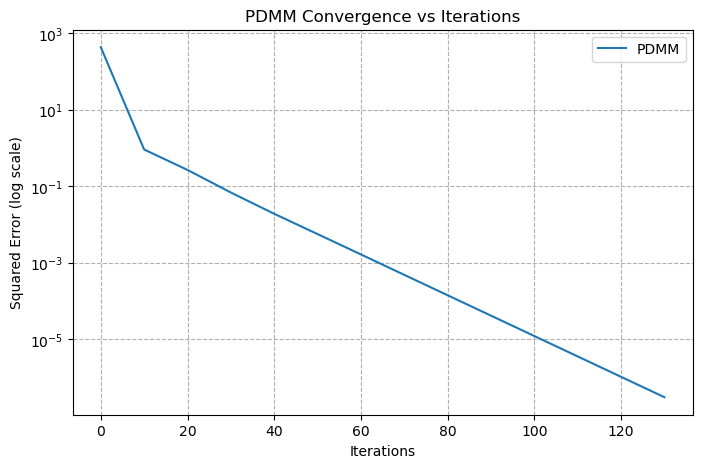

In [46]:
# ------------------ Visualization: error vs iteration ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history_pdmm['errors'])) * 10, history_pdmm['errors'], label='PDMM')
plt.xlabel('Iterations')
plt.ylabel('Squared Error (log scale)')
plt.title('PDMM Convergence vs Iterations')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

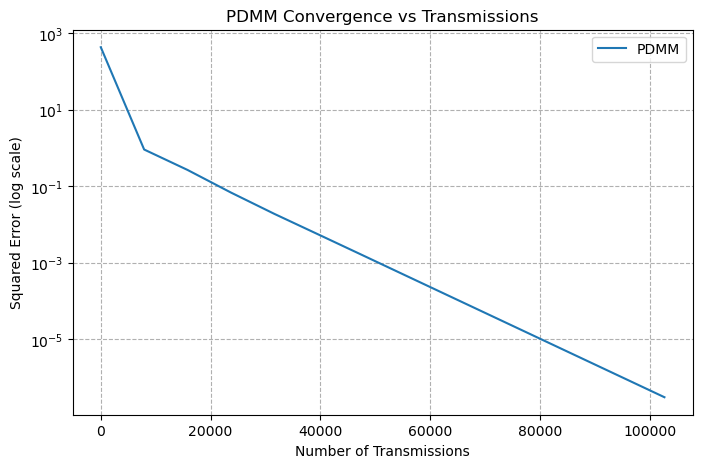

In [47]:
# ------------------ Visualization: error vs number of transmissions ------------------
edge_count = np.sum(adj_matrix) // 2
x_trans = np.arange(len(history_pdmm['errors'])) * 10 * 2 * edge_count
plt.figure(figsize=(8, 5))
plt.semilogy(x_trans, history_pdmm['errors'], label='PDMM')
plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('PDMM Convergence vs Transmissions')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

In [48]:
# ------------------ Output total number of transmissions ------------------
print("Total number of transmissions used by PDMM:", history_pdmm['transmissions'])

Total number of transmissions used by PDMM: 102700


## Q3